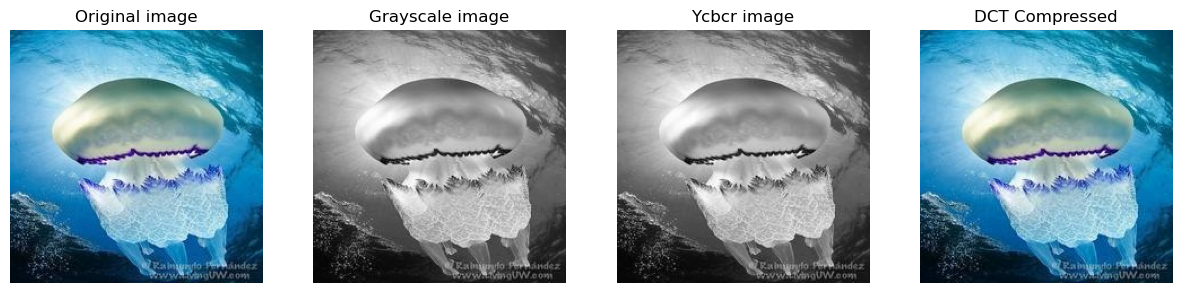

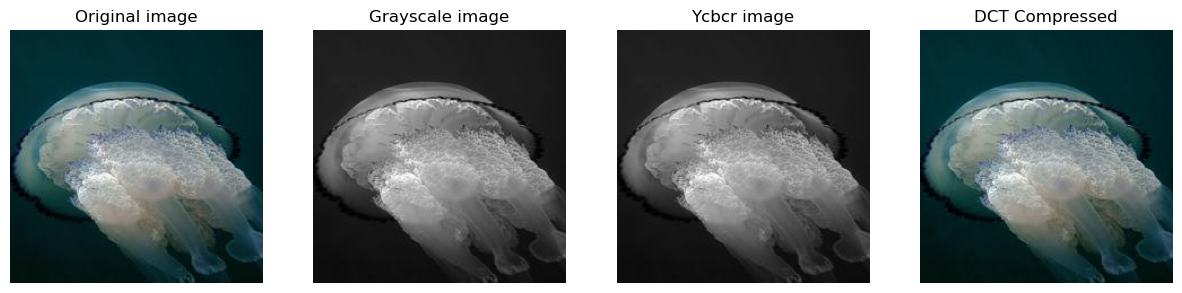

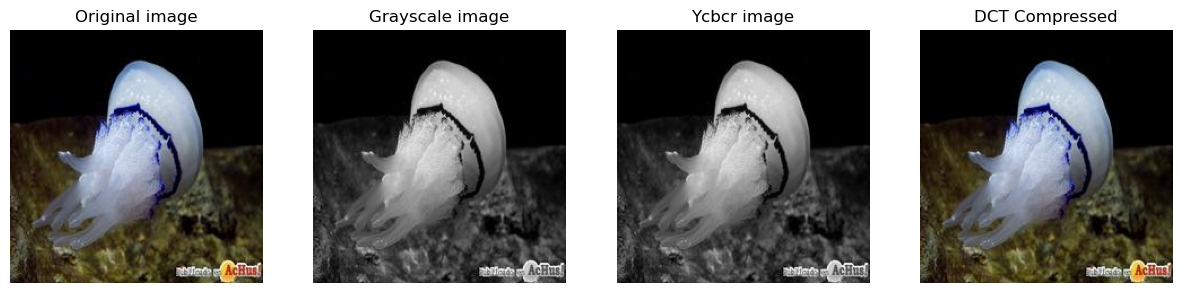

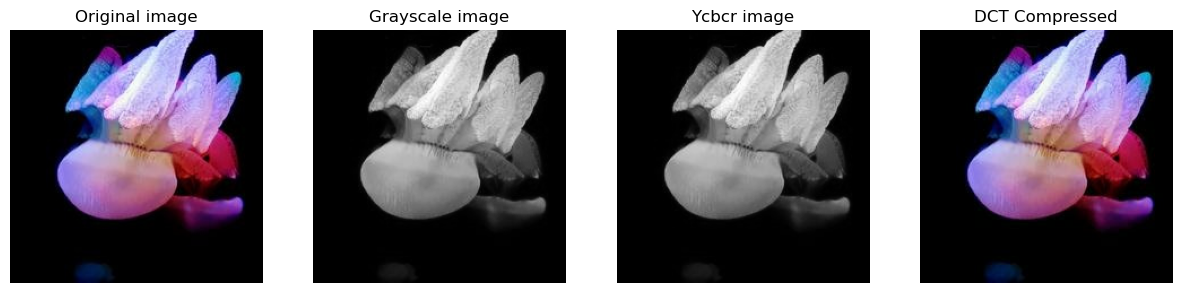

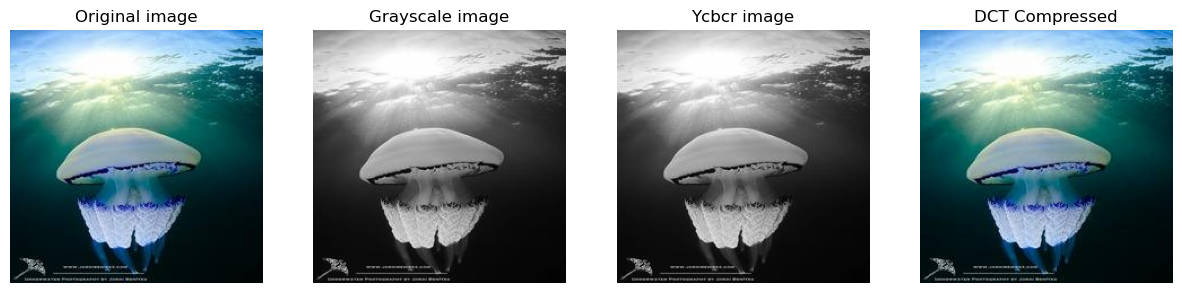

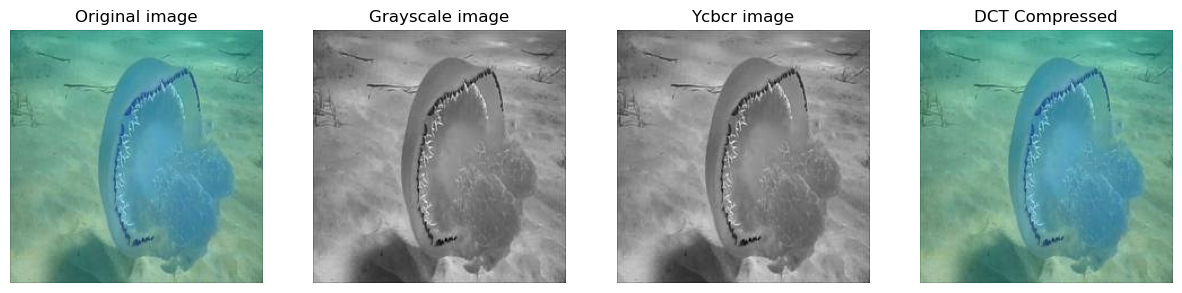

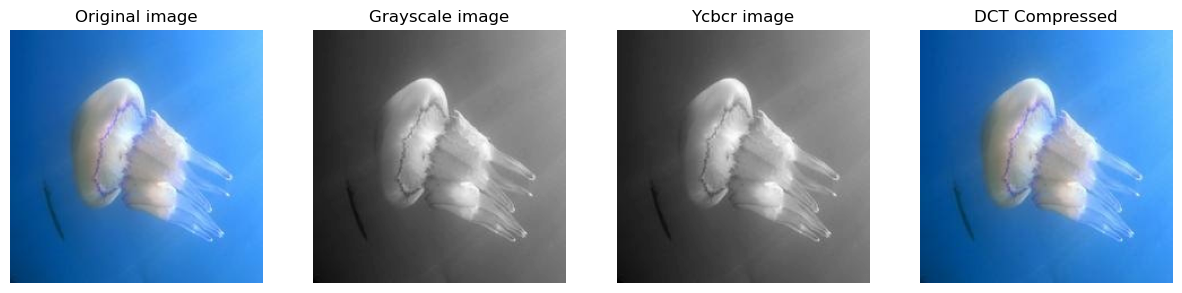

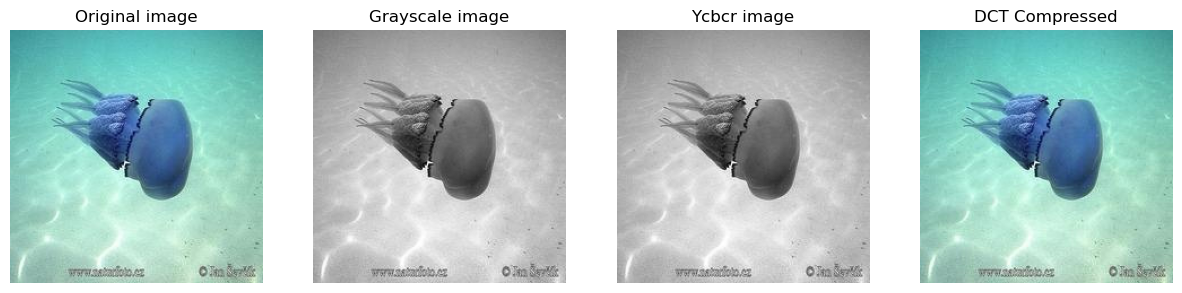

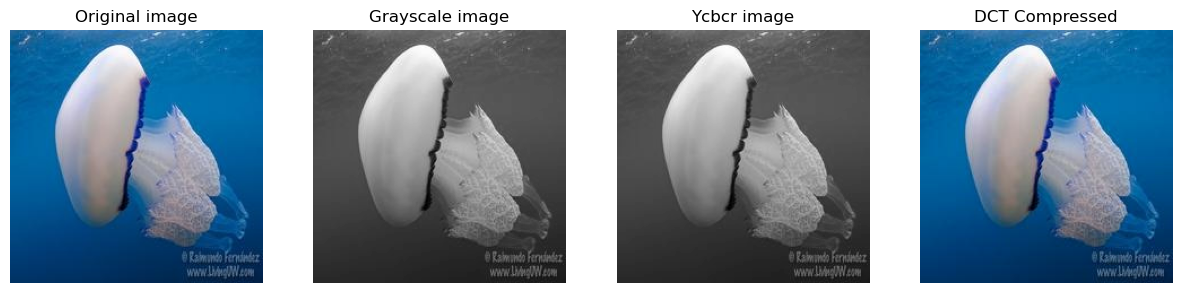

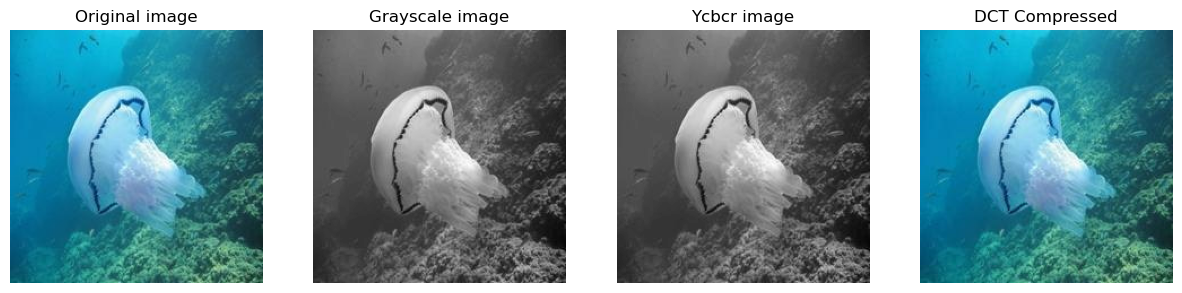

In [3]:
import cv2
import numpy as np
from scipy.fftpack import dct, idct
import os
import matplotlib.pyplot as plt

INPUT_DIR = r"C:\Users\ML\Downloads\archive (5)\barrel_jellyfish"
OUTPUT_DIR = os.path.join(INPUT_DIR, "DCT_compressed")
os.makedirs(OUTPUT_DIR, exist_ok=True)

def dct2(block):
    return dct(dct(block.T, norm='ortho').T, norm='ortho')

def idct2(block):
    return idct(idct(block.T, norm='ortho').T, norm='ortho')

def compress_image(img, quality=30, block_size=8):
    """Compress image using DCT on YCbCr channels"""
    ycbcr = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb).astype(np.float32)
    h, w, _ = ycbcr.shape
    
    # Quantization matrix (simple)
    Q = np.ones((block_size, block_size)) * (100-quality)/10 + 1
    Q[0,0] = 1
    
    # Pad image to be divisible by block_size
    padded_h = int(np.ceil(h / block_size) * block_size)
    padded_w = int(np.ceil(w / block_size) * block_size)
    padded = np.zeros((padded_h, padded_w, 3), dtype=np.float32)
    padded[:h,:w,:] = ycbcr
    compressed = np.zeros_like(padded)
    
    # DCT compression per channel
    for ch in range(3):
        for i in range(0, padded_h, block_size):
            for j in range(0, padded_w, block_size):
                block = padded[i:i+block_size, j:j+block_size, ch] - 128
                block = np.round(dct2(block)/Q) * Q
                compressed[i:i+block_size, j:j+block_size, ch] = idct2(block) + 128
                
    compressed = np.clip(compressed[:h,:w,:], 0, 255).astype(np.uint8)
    return cv2.cvtColor(compressed, cv2.COLOR_YCrCb2BGR), ycbcr.astype(np.uint8)

display_count = 0
for file in os.listdir(INPUT_DIR):
    if not file.lower().endswith((".jpg", ".png")):
        continue
    
    path = os.path.join(INPUT_DIR, file)
    img = cv2.imread(path)
    if img is None:
        continue
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    compressed_img, ycbcr_img = compress_image(img, quality=30)
    
    # Save compressed image
    base, ext = os.path.splitext(file)
    cv2.imwrite(os.path.join(OUTPUT_DIR, f"{base}_dct.jpg"), compressed_img)
    
    # Display first 10 images
    if display_count < 10:
        plt.figure(figsize=(15,4))
        
        plt.subplot(1,4,1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title("Original image"); plt.axis('off')
        
        plt.subplot(1,4,2)
        plt.imshow(gray, cmap='gray')
        plt.title("Grayscale image"); plt.axis('off')
        
        plt.subplot(1,4,3)
        plt.imshow(ycbcr_img[:,:,0], cmap='gray')
        plt.title("Ycbcr image"); plt.axis('off')
        
        plt.subplot(1,4,4)
        plt.imshow(cv2.cvtColor(compressed_img, cv2.COLOR_BGR2RGB))
        plt.title("DCT Compressed"); plt.axis('off')
        
        plt.show()
        display_count += 1


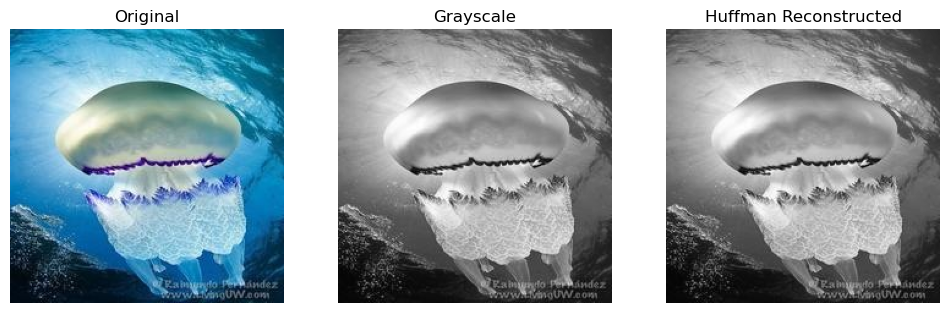

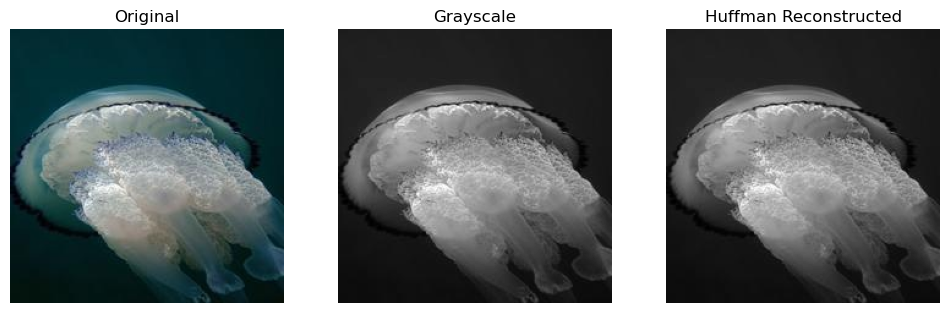

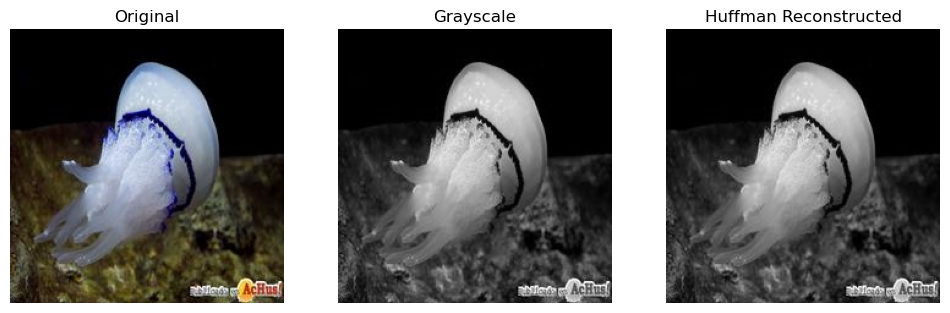

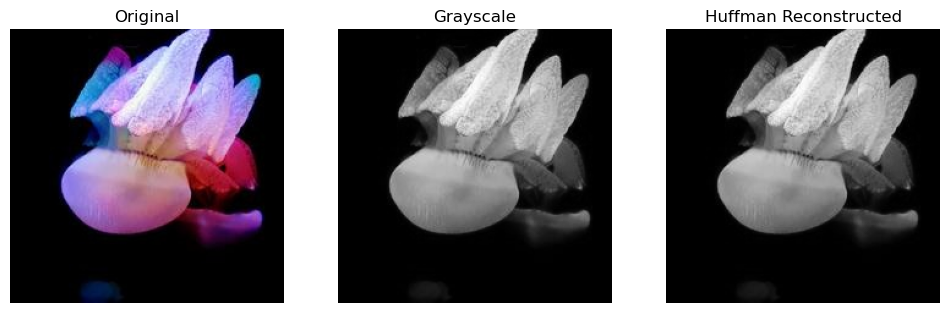

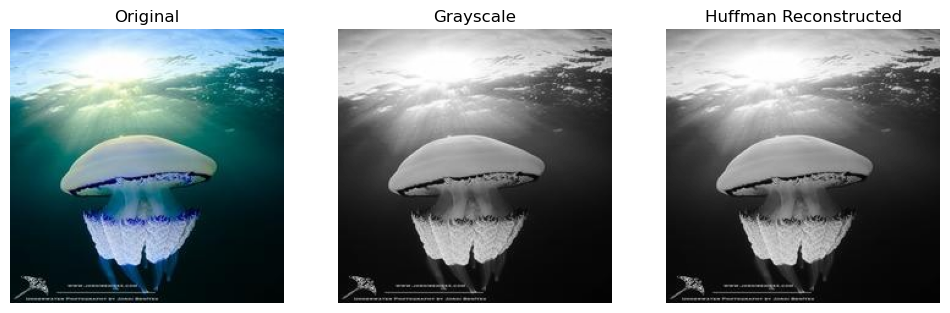

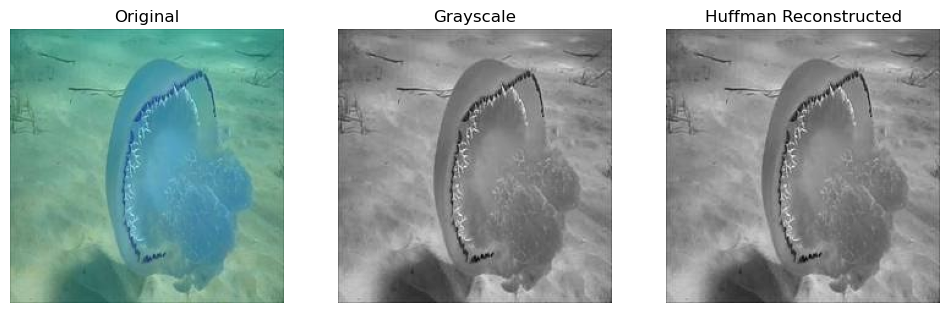

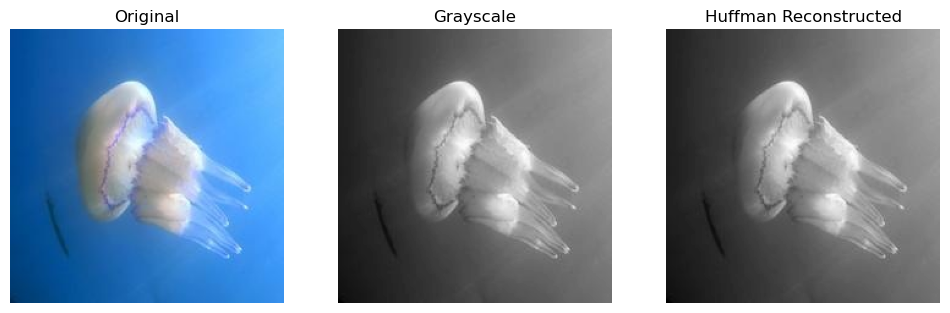

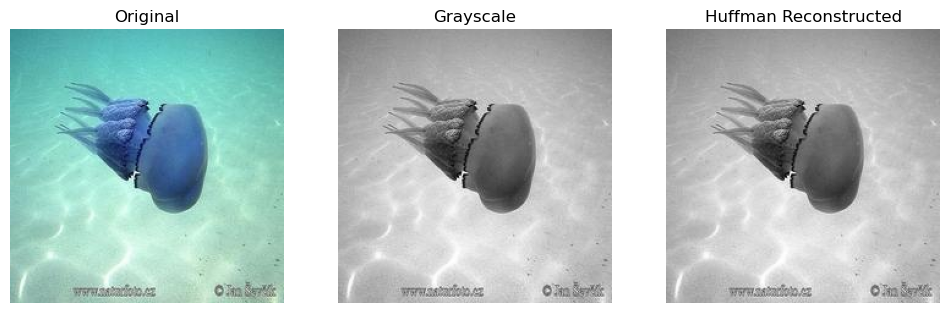

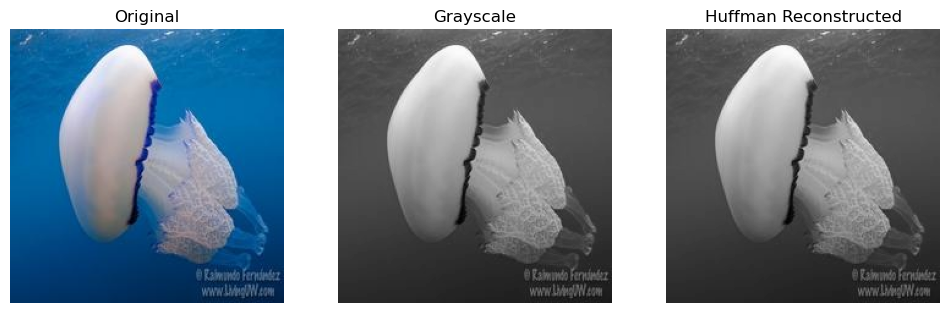

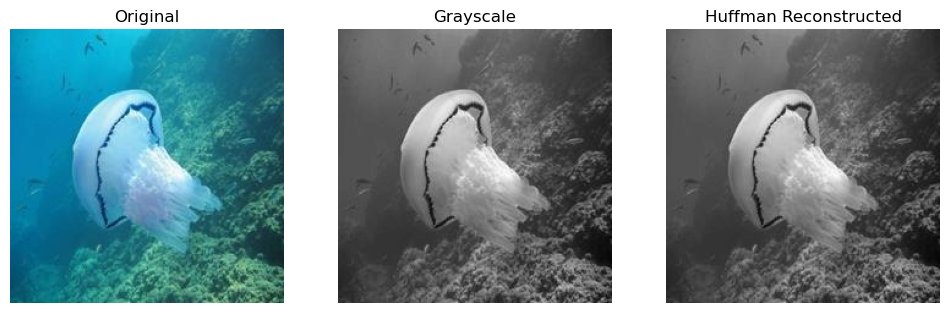

In [7]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import heapq

# ------------------------
# Huffman Coding Functions
# ------------------------
class HuffmanNode:
    def __init__(self, value=None, freq=0):
        self.value = value
        self.freq = freq
        self.left = None
        self.right = None
    def __lt__(self, other):
        return self.freq < other.freq

def build_huffman_tree(frequencies):
    heap = [HuffmanNode(v, f) for v, f in frequencies.items()]
    heapq.heapify(heap)
    while len(heap) > 1:
        node1 = heapq.heappop(heap)
        node2 = heapq.heappop(heap)
        merged = HuffmanNode(freq=node1.freq + node2.freq)
        merged.left = node1
        merged.right = node2
        heapq.heappush(heap, merged)
    return heap[0]

def build_codes(node, prefix="", codebook=None):
    if codebook is None:
        codebook = {}
    if node.value is not None:
        codebook[node.value] = prefix
    else:
        build_codes(node.left, prefix + "0", codebook)
        build_codes(node.right, prefix + "1", codebook)
    return codebook

def huffman_encode(image):
    flat = image.flatten()
    freqs = Counter(flat)
    tree = build_huffman_tree(freqs)
    codes = build_codes(tree)
    encoded = ''.join(codes[pixel] for pixel in flat)
    return encoded, codes, tree

def huffman_decode(encoded, tree, shape):
    reverse_codes = {}
    def build_reverse(node, prefix=""):
        if node.value is not None:
            reverse_codes[prefix] = node.value
        else:
            build_reverse(node.left, prefix + "0")
            build_reverse(node.right, prefix + "1")
    build_reverse(tree)
    
    decoded = []
    code = ""
    for bit in encoded:
        code += bit
        if code in reverse_codes:
            decoded.append(reverse_codes[code])
            code = ""
    return np.array(decoded, dtype=np.uint8).reshape(shape)

# ------------------------
# Paths
# ------------------------
INPUT_DIR = r"C:\Users\ML\Downloads\archive (5)\barrel_jellyfish"
OUTPUT_DIR = os.path.join(INPUT_DIR, "Huffman_Compressed")
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ------------------------
# Process Images
# ------------------------
display_count = 0
for file in os.listdir(INPUT_DIR):
    if not file.lower().endswith((".jpg", ".png")):
        continue
    
    path = os.path.join(INPUT_DIR, file)
    img = cv2.imread(path)
    if img is None:
        continue
    
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Huffman encode & decode
    encoded, codes, tree = huffman_encode(gray)
    decoded = huffman_decode(encoded, tree, gray.shape)
    
    # Display original, grayscale, Huffman reconstructed
    if display_count < 10:
        plt.figure(figsize=(12,4))
        
        plt.subplot(1,3,1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title("Original")
        plt.axis('off')
        
        plt.subplot(1,3,2)
        plt.imshow(gray, cmap='gray')
        plt.title("Grayscale")
        plt.axis('off')
        
        plt.subplot(1,3,3)
        plt.imshow(decoded, cmap='gray')
        plt.title("Huffman Reconstructed")
        plt.axis('off')
        
        plt.show()
        display_count += 1
